In [2]:
import pandas as pd
import numpy as np
import tqdm
import os
import gc
import copy

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Extract data and Divide into train/test

Here, we will extract all the information regarding train and test data

In [3]:
file_path = "C:\\UMD\\Sem 2\\MSML605 Computing Systems\\Homeworks\\Project\\CUB_200_2011"

images = pd.read_csv(f"{file_path}\\images.txt", 
                     sep=' ', 
                     names=['image_id', 'image_name'])
train_test = pd.read_csv(f"{file_path}\\train_test_split.txt", 
                     sep=' ', 
                     names=['image_id', 'is_training_image'])
classes = pd.read_csv(f"{file_path}\\classes.txt", 
                     sep=' ', 
                     names=['class_id', 'class_name'])
image_class_labels = pd.read_csv(f"{file_path}\\image_class_labels.txt", 
                     sep=' ', 
                     names=['image_id', 'class_id'])

bounding_boxes = pd.read_csv(f'{file_path}\\bounding_boxes.txt',
                             sep=' ',
                             names=['image_id', 'x', 'y', 'width', 'height'])
bounding_boxes = bounding_boxes.astype(int)
#Merging the information given
image_data = images.merge(train_test, on='image_id', how='inner')

labels_data = classes.merge(image_class_labels, on='class_id', how='inner')

image_data = image_data.merge(labels_data, on='image_id', how='inner')

image_data = image_data.merge(bounding_boxes, on='image_id', how='inner')
image_data

,image_id,image_name,is_training_image,class_id,class_name,x,y,width,height
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,60,27,325,304
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,139,30,153,264
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,14,112,388,186
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,112,90,255,242
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,70,50,134,303
...,...,...,...,...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,200,200.Common_Yellowthroat,89,95,354,250
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,200,200.Common_Yellowthroat,157,62,184,219
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,200,200.Common_Yellowthroat,190,102,198,202
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,200,200.Common_Yellowthroat,3,20,408,307


Now, we divide into train and test data using the information given

In [4]:
# Set the first 24 training values in each group to 0 
grouped = image_data[image_data['is_training_image'] == 1].groupby('class_name')
validation_indices = []

for name, group in grouped: 
    validation_indices.extend(group.index[24:])

# Set the first 24 values in each group to 0
image_data['is_validation_image'] = 0
image_data.loc[validation_indices, 'is_validation_image'] = 1
image_data['is_validation_image'].value_counts()

is_validation_image
0    10594
1     1194
Name: count, dtype: int64

In [5]:
#Split the data into training and test
train_indices = (image_data['is_training_image'] == 1) & (image_data['is_validation_image'] == 0)
training_data = image_data[train_indices].reset_index()
validation_data = image_data[image_data['is_validation_image'] == 1].reset_index()
test_data = image_data[image_data['is_training_image'] == 0].reset_index()

#Setting three sets of images: training, validation, and test
X_temp_train = []
X_temp_validation = []
X_temp_test = []
temp = [X_temp_train, X_temp_validation, X_temp_test]

for p, dataframe in enumerate([training_data, validation_data, test_data]):
    #Get the paths for the images
    paths = 'CUB_200_2011/images/' + np.array(dataframe['image_name'])
    
    #Get the image arrays
    for i, img in tqdm.tqdm(enumerate(paths), total=dataframe.shape[0]):
        image = cv2.imread(img)
        x, y, width, height = dataframe.loc[i, ['x', 'y', 'width', 'height']]
        temp[p].append(image[y:y+height, x:x+width, :])
    
len(X_temp_train), len(X_temp_validation), len(X_temp_test)

  0%|          | 0/4800 [00:00<?, ?it/s]

100%|██████████| 5794/5794 [01:12<00:00, 79.62it/s]


(4800, 1194, 5794)

# Data Preprocessing

Padding all to square and then reshaping all to 224x224

In [6]:
def convert_to_PIL(image):
    return Image.fromarray(image)

# Define the transformation pipeline
transform = transforms.Compose([
    convert_to_PIL,
    # transforms.Resize(256),  # Resize the shorter side to 256, preserving aspect ratio
    # transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


final_image_size = (224, 224)


In [7]:
X_train, X_validation, X_test = [], [], []
for i, img in tqdm.tqdm(enumerate(X_temp_train), total=len(X_temp_train)):
    X_train.append(transform(img))

for i, img in tqdm.tqdm(enumerate(X_temp_validation), total=len(X_temp_validation)):
    X_validation.append(transform(img))

for i, img in tqdm.tqdm(enumerate(X_temp_test), total=len(X_temp_test)):
    X_test.append(transform(img))

100%|██████████| 5794/5794 [00:34<00:00, 167.90it/s]


In [8]:
y_train = np.array(image_data[train_indices]['class_id']) - 1

In [9]:
# train_transform = transforms.Compose([
#     convert_to_PIL,
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(10),
#     transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.RandomErasing(inplace=True),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# for i, img in tqdm.tqdm(enumerate(X_temp_train), total=len(X_temp_train)):
#     X_train.append(train_transform(img))

# y_train = np.array(image_data[train_indices]['class_id']) - 1
# y_train = np.concatenate([y_train, y_train])

In [10]:
# Convert the list of tensors to a 4D tensor (N, H, W, C)
X_train = torch.stack(X_train)   
print("Train done")

X_validation = torch.stack(X_validation) 
print("Validation done")

X_test = torch.stack(X_test)
print("Test done")   

print(X_train.shape, X_validation.shape, X_test.shape)

Train done
Validation done
Test done
torch.Size([4800, 3, 224, 224]) torch.Size([1194, 3, 224, 224]) torch.Size([5794, 3, 224, 224])


Setting labels

In [11]:
# Set the labels for training, validation and test
# y_validation = np.array(image_data[image_data['is_validation_image'] == 1]['class_id']) - 1
y_validation = np.array(image_data[image_data['is_validation_image'] == 1]['class_id']) - 1
y_test = np.array(image_data[image_data['is_training_image'] == 0]['class_id']) - 1

# dtype=torch.float, torch.long
y_train = torch.Tensor(y_train)
y_validation = torch.Tensor(y_validation).long()
y_test = torch.Tensor(y_test).long()
len(y_train), len(y_validation), len(y_test)

(4800, 1194, 5794)

Creating DataLoader

In [12]:
TrainDataset = data.TensorDataset(X_train, y_train)
ValidationDataset = data.TensorDataset(X_validation, y_validation)
TestDataset = data.TensorDataset(X_test, y_test)

batch_size = 2
TrainLoader = data.DataLoader(dataset=TrainDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

ValidationLoader = data.DataLoader(dataset=ValidationDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

TestLoader = data.DataLoader(dataset=TestDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

len(TrainDataset), len(ValidationDataset), len(TestDataset)

(4800, 1194, 5794)

In [13]:
gc.collect()
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


GroundTruth:  25.0 189.0


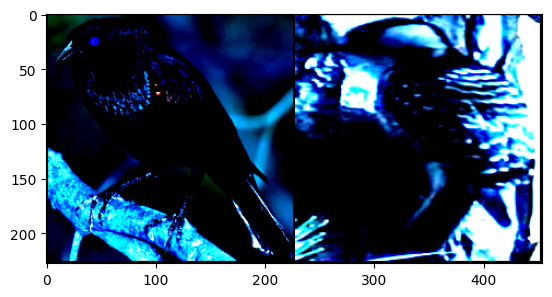

In [14]:
dataiter = iter(TrainLoader)
images, labels = next(dataiter)

# print images
plt.imshow(torchvision.utils.make_grid(images, nrow=10).permute(1, 2, 0))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(2)))

Calculating accuracy function

In [15]:
def calculate_accuracy(model, loader, data_type='training'):
    model.eval() # Set model to evaluation mode

    correct = total = 0
    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            #For training, there will be onehot vector, so convert from onehot
            if data_type == 'training': 
                _, labels = torch.max(labels.data, 1)
            
            #Compare with ground truth
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the {len(loader)} {data_type} images: {100 * correct / total}')
    return 100 * correct/total
    


# Feature Extraction

In [20]:
models.densenet121()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [16]:
# Load the pretrained ResNet-18 model
NewModel = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)


# Modify the final fully connected layers
num_classes = 200  # Replace with the number of bird species

# Redefine the fc layers
# NewModel.classifier = nn.Linear(NewModel.classifier.in_features, num_classes)
NewModel.classifier = nn.Identity()

# Unfreeze all layers 
for param in NewModel.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()


NewModel.to(device)


c:\UMD\.venv\Lib\site-packages\torch\nn\modules\module.py:1159: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
TrainFeatures = []
ValidationFeatures = []
TestFeatures = []

TrainLabels = []
ValidationLabels = []
TestLabels = []

def get_features(model, loader, features, classified_labels):
    model.eval() # Set model to evaluation mode

    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            features.extend(outputs.cpu())
            classified_labels.extend(labels.cpu())
    return features, classified_labels

TrainFeatures, TrainLabels = get_features(NewModel, TrainLoader, 
                                          TrainFeatures, TrainLabels)
ValidationFeatures, ValidationLabels = get_features(NewModel, ValidationLoader, 
                                                    ValidationFeatures, ValidationLabels)
TestFeatures, TestLabels = get_features(NewModel, TestLoader, 
                                        TestFeatures, TestLabels)


100%|██████████| 2897/2897 [02:00<00:00, 24.03it/s]


In [18]:
TrainFeatures = torch.stack(TrainFeatures)
ValidationFeatures = torch.stack(ValidationFeatures)
TestFeatures = torch.stack(TestFeatures)

TrainLabels = torch.stack(TrainLabels)
ValidationLabels = torch.stack(ValidationLabels)
TestLabels = torch.stack(TestLabels)

TrainFeatures.shape, ValidationFeatures.shape, TestFeatures.shape

(torch.Size([4800, 1024]), torch.Size([1194, 1024]), torch.Size([5794, 1024]))

In [19]:
TrainFeatureDataset = torch.utils.data.TensorDataset(TrainFeatures, TrainLabels)
ValidationFeatureDataset = torch.utils.data.TensorDataset(ValidationFeatures, ValidationLabels)
TestFeatureDataset = torch.utils.data.TensorDataset(TestFeatures, TestLabels)

batch_size = 128
TrainFeatureLoader = torch.utils.data.DataLoader(dataset=TrainFeatureDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)
ValidationFeatureLoader = torch.utils.data.DataLoader(dataset=ValidationFeatureDataset, batch_size=batch_size,
                                 shuffle=True, num_workers=4, pin_memory=True)
TestFeatureLoader = torch.utils.data.DataLoader(dataset=TestFeatureDataset, batch_size=batch_size,
                                 shuffle=True, num_workers=4, pin_memory=True)

len(TrainFeatureDataset), len(ValidationFeatureDataset), len(TestFeatureDataset), \
len(TrainFeatureLoader), len(ValidationFeatureLoader), len(TestFeatureLoader)

(4800, 1194, 5794, 38, 10, 46)

# Model

In [23]:
class NeuralNetwork1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork1D, self).__init__()
        self.linear1 = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear1(x)
        return out

In [50]:
model_1d = NeuralNetwork1D(1024, 200)
model_1d.to(device)

NeuralNetwork1D(
  (linear1): Linear(in_features=1024, out_features=200, bias=True)
)

## Check Initial Loss

log(C) for softmax for C classes

In [51]:
def calculate_loss(model, loader, criterion):
    model.eval() # Set model to evaluation mode

    running_loss = 0
    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            running_loss += loss.item()

    return running_loss / len(loader)

calculate_loss(model_1d, TrainFeatureLoader, criterion)


100%|██████████| 38/38 [00:02<00:00, 13.22it/s]


5.424873050890471

In [52]:
- np.log(1/200)

5.298317366548036

We can observe that the loss is nearly as expected. This means that our model is not making any mistake.

The loss should be $log(C)$ where $C$ is the number of classes.

The reason is that the cross entropy is defined as 
$$\frac{1}{N}\sum_{i = 1}^{N}-y_i log(p_i)$$ 
where $y_i = 1$ for correct $i$ and the probability $p_i = \frac{1}{C}$

## Overfit a small sample

We need to get 100% training accuracy on a small sample of training data (5 - 10 minibatches). No weight initialization and regularization.

Bad initialization conditions
- If loss is not going down, LR is too low 
- If loss explodes to `np.inf` or `NaN`, LR is too high

In [53]:
def overfit_model(NewModel, Loader, optimizer, criterion, num_epochs=30):
    training_loss = []
    training_accuracy = []

    for epoch in range(num_epochs):
        NewModel.train()

        running_loss = 0    
        for input_data, labels in tqdm.tqdm(Loader, total=len(Loader)):
            # Forward pass
            labels, input_data = labels.to(device), input_data.to(device)
            output = NewModel(input_data)
            
            # Compute loss
            loss = criterion(output, labels.long())
            running_loss += loss.item()
            # Backward pass
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
            
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        training_loss.append(running_loss / len(Loader))
        training_accuracy.append(calculate_accuracy(NewModel, Loader, data_type='train'))
    
    return training_loss, training_accuracy

def plot_training_plots(training_loss, training_accuracy):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].plot(range(len(training_loss)), training_loss)
    ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
    ax[1].grid()
    ax[0].grid()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.show()

100%|██████████| 38/38 [00:02<00:00, 13.19it/s]


Epoch [1/5], Loss: 4.3553


100%|██████████| 38/38 [00:02<00:00, 14.66it/s]


Accuracy of the network on the 38 train images: 29.833333333333332


100%|██████████| 38/38 [00:02<00:00, 13.16it/s]


Epoch [2/5], Loss: 3.1446


100%|██████████| 38/38 [00:02<00:00, 14.70it/s]


Accuracy of the network on the 38 train images: 55.9375


100%|██████████| 38/38 [00:02<00:00, 14.35it/s]


Epoch [3/5], Loss: 2.6127


100%|██████████| 38/38 [00:02<00:00, 15.15it/s]


Accuracy of the network on the 38 train images: 66.16666666666667


100%|██████████| 38/38 [00:02<00:00, 14.74it/s]


Epoch [4/5], Loss: 2.2310


100%|██████████| 38/38 [00:02<00:00, 15.00it/s]


Accuracy of the network on the 38 train images: 74.10416666666667


100%|██████████| 38/38 [00:02<00:00, 14.15it/s]


Epoch [5/5], Loss: 1.7117


100%|██████████| 38/38 [00:02<00:00, 15.21it/s]

Accuracy of the network on the 38 train images: 80.52083333333333


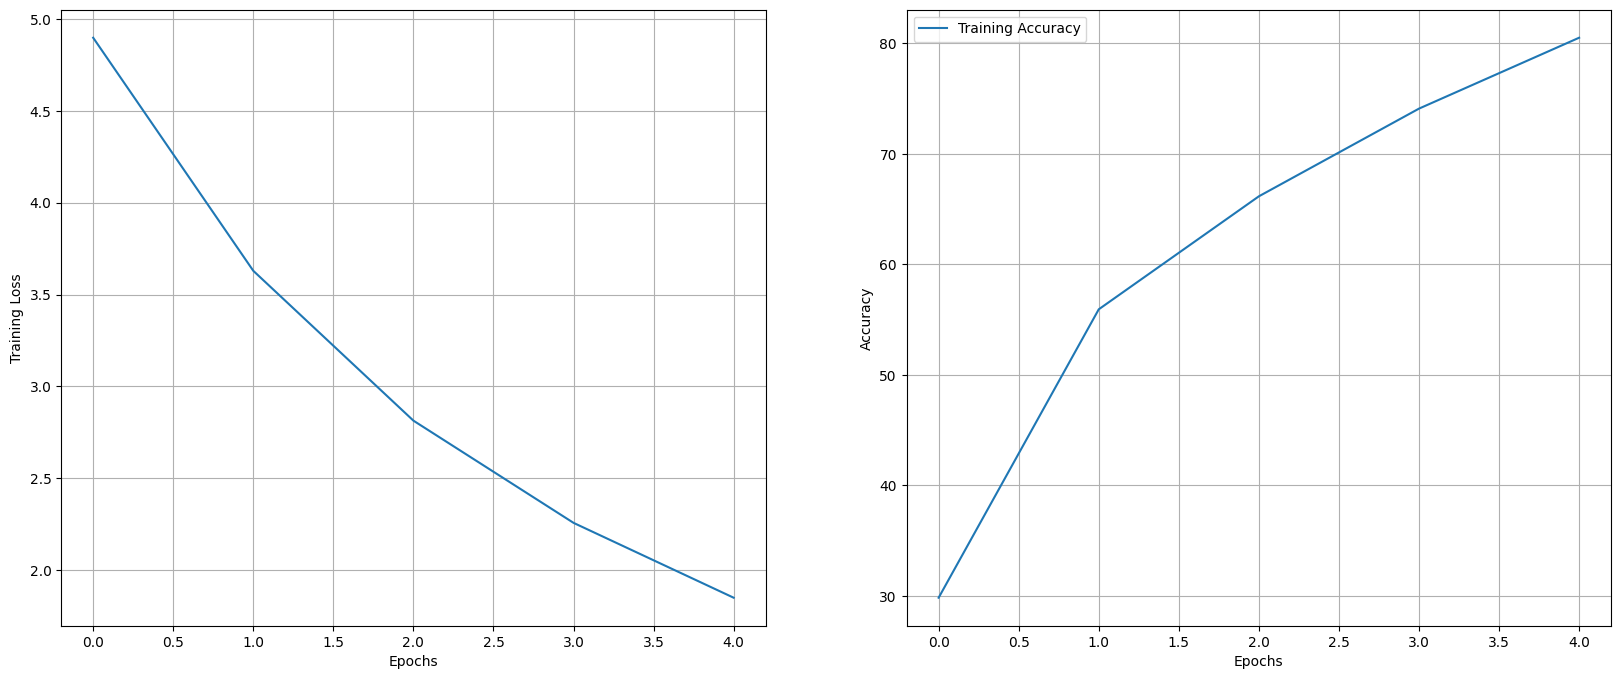

In [56]:
checkModel = copy.deepcopy(model_1d)
checkModel.to(device)

optimizer = optim.Adam(params=checkModel.parameters(), lr=0.001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

adam_training_loss, adam_training_accuracy = overfit_model(checkModel, TrainFeatureLoader, optimizer, criterion, num_epochs=5)
plot_training_plots(adam_training_loss, adam_training_accuracy)

We can observe that Adam optimizer can overfit a sample with the given optimizers.

100%|██████████| 38/38 [00:02<00:00, 14.72it/s]


Epoch [1/5], Loss: 5.3143


100%|██████████| 38/38 [00:02<00:00, 14.81it/s]


Accuracy of the network on the 38 train images: 0.7291666666666666


100%|██████████| 38/38 [00:02<00:00, 15.07it/s]


Epoch [2/5], Loss: 5.3361


100%|██████████| 38/38 [00:02<00:00, 14.58it/s]


Accuracy of the network on the 38 train images: 0.7083333333333334


100%|██████████| 38/38 [00:02<00:00, 14.69it/s]


Epoch [3/5], Loss: 5.3964


100%|██████████| 38/38 [00:02<00:00, 15.14it/s]


Accuracy of the network on the 38 train images: 0.8125


100%|██████████| 38/38 [00:02<00:00, 14.70it/s]


Epoch [4/5], Loss: 5.2551


100%|██████████| 38/38 [00:02<00:00, 14.37it/s]


Accuracy of the network on the 38 train images: 0.875


100%|██████████| 38/38 [00:02<00:00, 14.70it/s]


Epoch [5/5], Loss: 5.3500


100%|██████████| 38/38 [00:02<00:00, 15.10it/s]

Accuracy of the network on the 38 train images: 0.9791666666666666


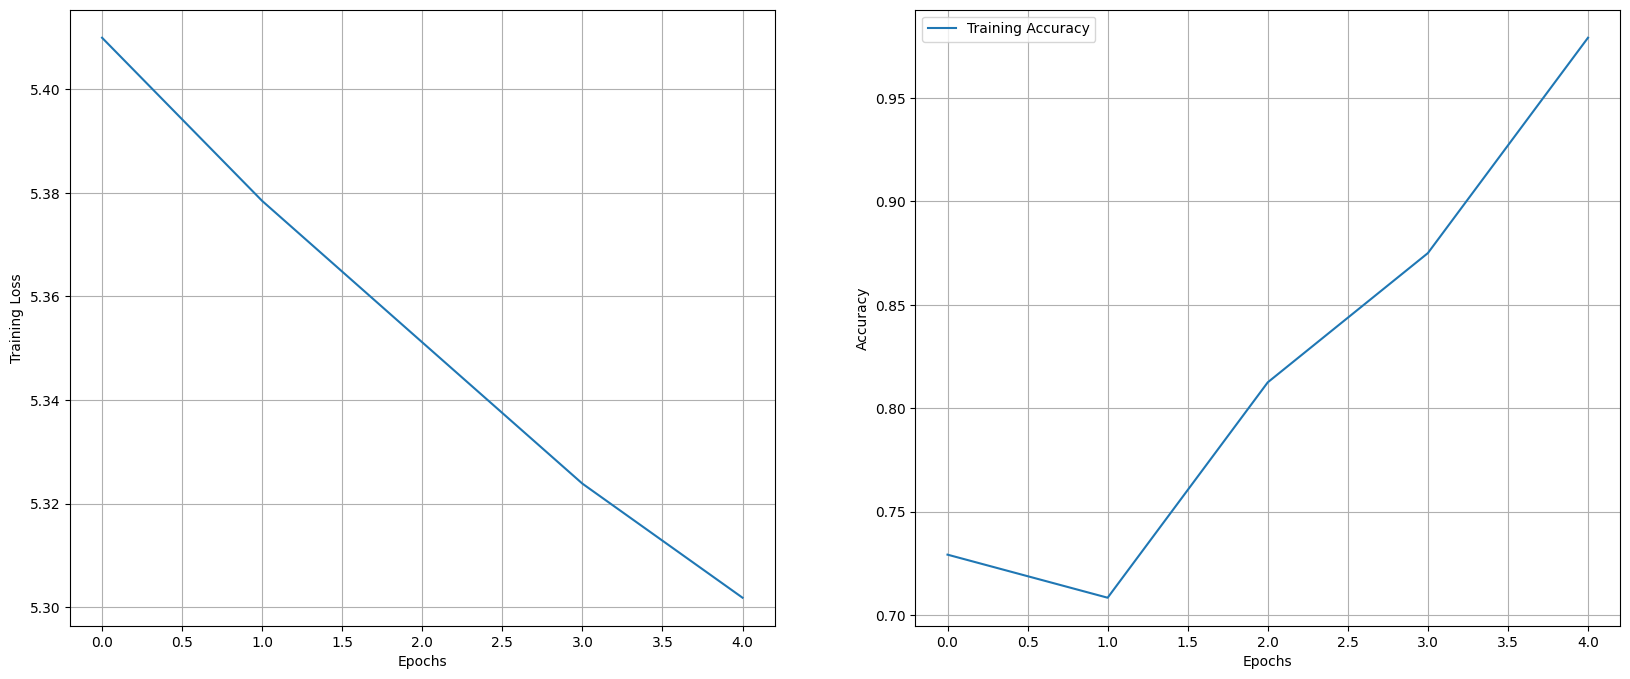

In [57]:
checkModel = copy.deepcopy(model_1d)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.SGD(params=checkModel.parameters(), lr=0.001, weight_decay=0)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

sgd_training_loss, sgd_training_accuracy = overfit_model(checkModel, TrainFeatureLoader, optimizer, criterion, num_epochs=5)
plot_training_plots(training_loss=sgd_training_loss, training_accuracy=sgd_training_accuracy)

100%|██████████| 38/38 [00:02<00:00, 14.65it/s]


Epoch [1/5], Loss: 5.2885


100%|██████████| 38/38 [00:02<00:00, 14.87it/s]


Accuracy of the network on the 38 train images: 1.3125


100%|██████████| 38/38 [00:02<00:00, 14.52it/s]


Epoch [2/5], Loss: 5.0876


100%|██████████| 38/38 [00:02<00:00, 14.40it/s]


Accuracy of the network on the 38 train images: 3.625


100%|██████████| 38/38 [00:02<00:00, 14.91it/s]


Epoch [3/5], Loss: 4.9704


100%|██████████| 38/38 [00:02<00:00, 14.89it/s]


Accuracy of the network on the 38 train images: 8.479166666666666


100%|██████████| 38/38 [00:02<00:00, 14.32it/s]


Epoch [4/5], Loss: 4.8131


100%|██████████| 38/38 [00:02<00:00, 14.84it/s]


Accuracy of the network on the 38 train images: 13.041666666666666


100%|██████████| 38/38 [00:02<00:00, 15.17it/s]


Epoch [5/5], Loss: 4.7021


100%|██████████| 38/38 [00:02<00:00, 15.21it/s]

Accuracy of the network on the 38 train images: 19.166666666666668


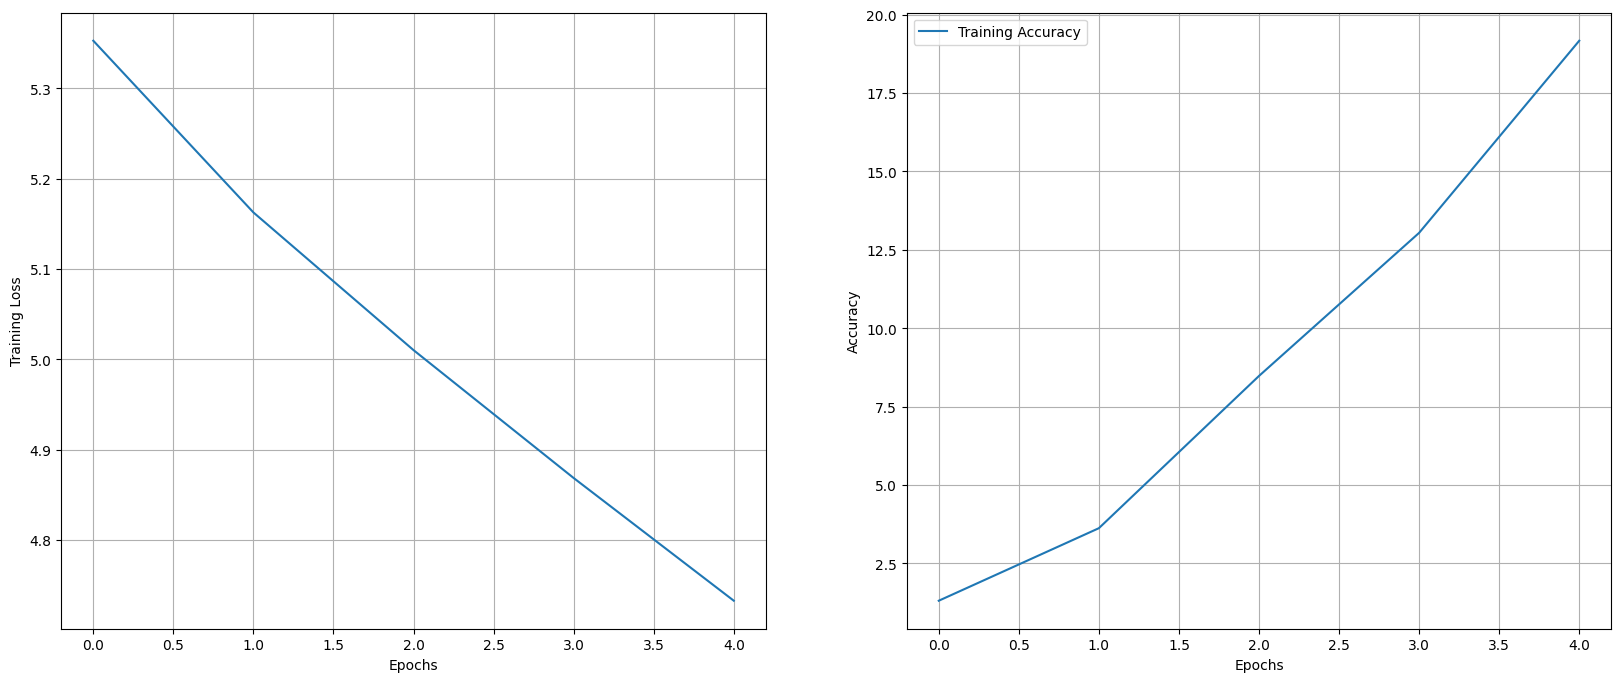

In [58]:
checkModel = copy.deepcopy(model_1d)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.SGD(params=checkModel.parameters(), lr=0.001, weight_decay=0, momentum=0.9)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

msgd_training_loss, msgd_training_accuracy = overfit_model(checkModel, TrainFeatureLoader, optimizer, criterion, num_epochs=5)
plot_training_plots(training_loss=msgd_training_loss, training_accuracy=msgd_training_accuracy)

100%|██████████| 38/38 [00:02<00:00, 14.71it/s]


Epoch [1/5], Loss: 4.2893


100%|██████████| 38/38 [00:03<00:00, 12.56it/s]


Accuracy of the network on the 38 train images: 32.041666666666664


100%|██████████| 38/38 [00:02<00:00, 15.10it/s]


Epoch [2/5], Loss: 3.2248


100%|██████████| 38/38 [00:02<00:00, 14.98it/s]


Accuracy of the network on the 38 train images: 53.354166666666664


100%|██████████| 38/38 [00:02<00:00, 14.98it/s]


Epoch [3/5], Loss: 2.6454


100%|██████████| 38/38 [00:02<00:00, 15.25it/s]


Accuracy of the network on the 38 train images: 66.1875


100%|██████████| 38/38 [00:02<00:00, 14.85it/s]


Epoch [4/5], Loss: 1.9370


100%|██████████| 38/38 [00:02<00:00, 15.15it/s]


Accuracy of the network on the 38 train images: 76.6875


100%|██████████| 38/38 [00:02<00:00, 14.05it/s]


Epoch [5/5], Loss: 1.5976


100%|██████████| 38/38 [00:02<00:00, 14.79it/s]

Accuracy of the network on the 38 train images: 80.47916666666667


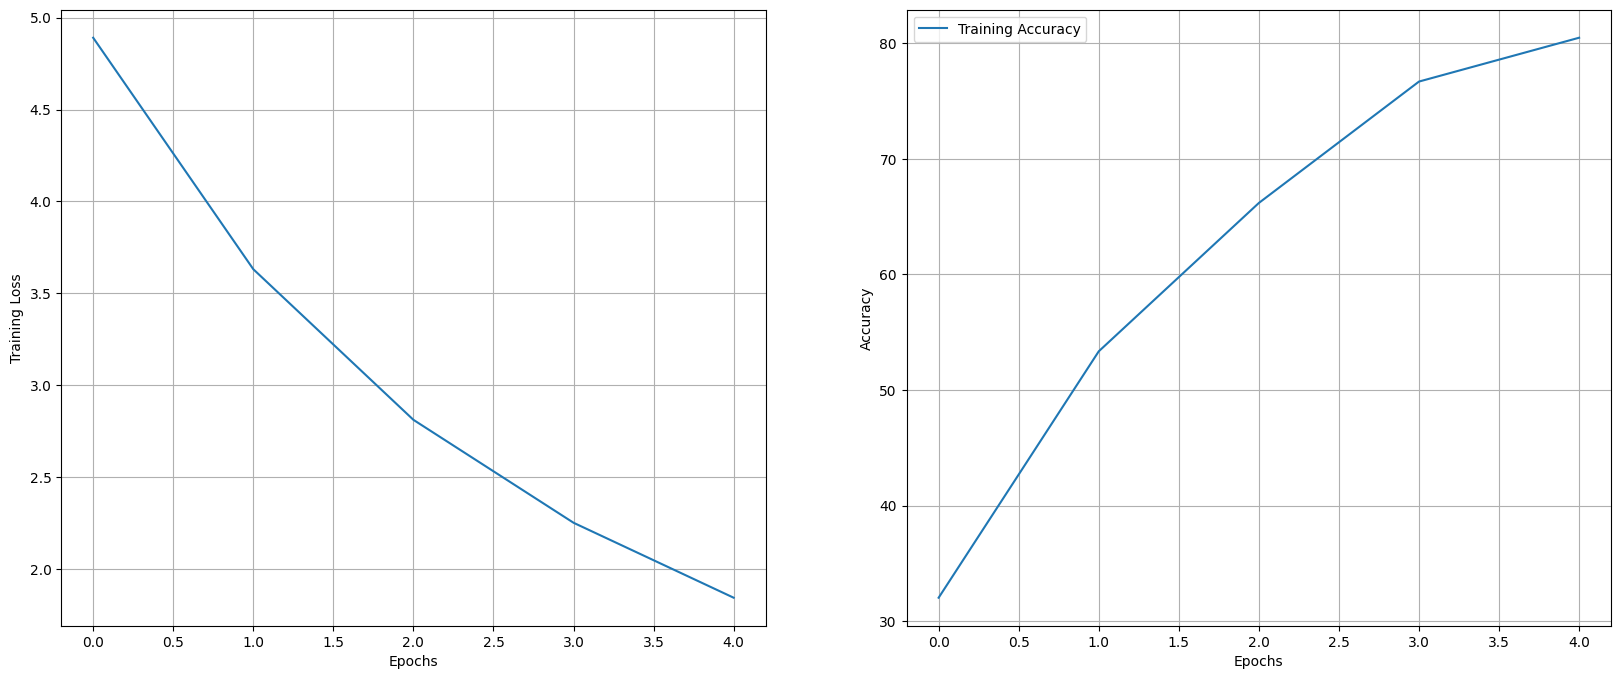

In [59]:
checkModel = copy.deepcopy(model_1d)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.AdamW(params=checkModel.parameters(), lr=0.001)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

adamW_training_loss, adamW_training_accuracy = overfit_model(checkModel, TrainFeatureLoader, optimizer, criterion, num_epochs=5)
plot_training_plots(training_loss=adamW_training_loss, training_accuracy=adamW_training_accuracy)

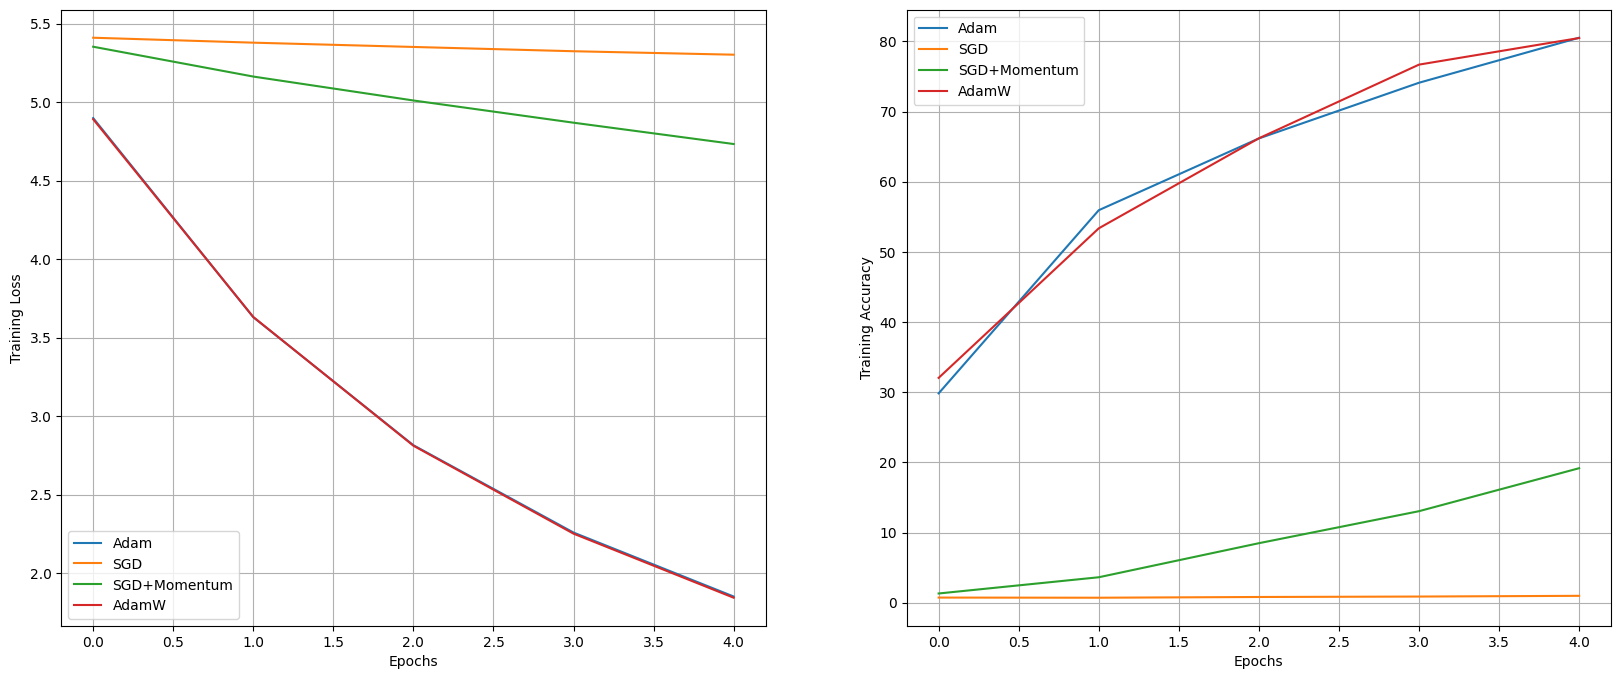

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(range(len(adam_training_loss)), adam_training_loss, label='Adam')
ax[0].plot(range(len(sgd_training_loss)), sgd_training_loss, label='SGD')
ax[0].plot(range(len(msgd_training_loss)), msgd_training_loss, label='SGD+Momentum')
ax[0].plot(range(len(adamW_training_loss)), adamW_training_loss, label='AdamW')

ax[1].plot(range(len(adam_training_accuracy)), adam_training_accuracy, label='Adam')
ax[1].plot(range(len(sgd_training_accuracy)), sgd_training_accuracy, label='SGD')
ax[1].plot(range(len(msgd_training_accuracy)), msgd_training_accuracy, label='SGD+Momentum')
ax[1].plot(range(len(adamW_training_accuracy)), adamW_training_accuracy, label='AdamW')

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Training Accuracy')

plt.show()

## Find Learning Rate that makes loss go down

Use the architecture from the previous step and use all training data, turn on small weight decay, find learning rate that makes the loss drop significantly (within 100 iterations)

Good learning rates: 1e-1, 1e-2, 1e-3, 1e-4

0.1


100%|██████████| 38/38 [00:03<00:00, 11.20it/s]


Epoch [1/5], Loss: 119.3377


100%|██████████| 38/38 [00:02<00:00, 15.04it/s]


Accuracy of the network on the 38 train images: 15.0


100%|██████████| 38/38 [00:02<00:00, 14.43it/s]


Epoch [2/5], Loss: 35.0364


100%|██████████| 38/38 [00:02<00:00, 14.82it/s]


Accuracy of the network on the 38 train images: 46.208333333333336


100%|██████████| 38/38 [00:02<00:00, 13.89it/s]


Epoch [3/5], Loss: 4.6394


100%|██████████| 38/38 [00:02<00:00, 14.54it/s]


Accuracy of the network on the 38 train images: 69.91666666666667


100%|██████████| 38/38 [00:02<00:00, 14.80it/s]


Epoch [4/5], Loss: 1.8222


100%|██████████| 38/38 [00:02<00:00, 14.74it/s]


Accuracy of the network on the 38 train images: 78.4375


100%|██████████| 38/38 [00:02<00:00, 14.90it/s]


Epoch [5/5], Loss: 2.7233


100%|██████████| 38/38 [00:02<00:00, 15.11it/s]


Accuracy of the network on the 38 train images: 81.95833333333333
0.01


100%|██████████| 38/38 [00:02<00:00, 15.08it/s]


Epoch [1/5], Loss: 3.1656


100%|██████████| 38/38 [00:02<00:00, 15.06it/s]


Accuracy of the network on the 38 train images: 55.020833333333336


100%|██████████| 38/38 [00:02<00:00, 14.63it/s]


Epoch [2/5], Loss: 0.9222


100%|██████████| 38/38 [00:02<00:00, 15.06it/s]


Accuracy of the network on the 38 train images: 74.25


100%|██████████| 38/38 [00:02<00:00, 14.74it/s]


Epoch [3/5], Loss: 0.8947


100%|██████████| 38/38 [00:02<00:00, 15.06it/s]


Accuracy of the network on the 38 train images: 87.14583333333333


100%|██████████| 38/38 [00:02<00:00, 14.60it/s]


Epoch [4/5], Loss: 0.5645


100%|██████████| 38/38 [00:02<00:00, 15.15it/s]


Accuracy of the network on the 38 train images: 94.02083333333333


100%|██████████| 38/38 [00:02<00:00, 14.51it/s]


Epoch [5/5], Loss: 0.1517


100%|██████████| 38/38 [00:02<00:00, 15.04it/s]


Accuracy of the network on the 38 train images: 95.54166666666667
0.001


100%|██████████| 38/38 [00:02<00:00, 14.97it/s]


Epoch [1/5], Loss: 4.2286


100%|██████████| 38/38 [00:02<00:00, 15.20it/s]


Accuracy of the network on the 38 train images: 26.083333333333332


100%|██████████| 38/38 [00:02<00:00, 14.81it/s]


Epoch [2/5], Loss: 3.2598


100%|██████████| 38/38 [00:02<00:00, 14.89it/s]


Accuracy of the network on the 38 train images: 56.020833333333336


100%|██████████| 38/38 [00:02<00:00, 14.43it/s]


Epoch [3/5], Loss: 2.5972


100%|██████████| 38/38 [00:02<00:00, 15.04it/s]


Accuracy of the network on the 38 train images: 69.75


100%|██████████| 38/38 [00:02<00:00, 14.33it/s]


Epoch [4/5], Loss: 2.0963


100%|██████████| 38/38 [00:02<00:00, 15.33it/s]


Accuracy of the network on the 38 train images: 76.25


100%|██████████| 38/38 [00:02<00:00, 13.15it/s]


Epoch [5/5], Loss: 1.8309


100%|██████████| 38/38 [00:02<00:00, 15.10it/s]


Accuracy of the network on the 38 train images: 80.72916666666667
0.0001


100%|██████████| 38/38 [00:02<00:00, 14.74it/s]


Epoch [1/5], Loss: 5.2178


100%|██████████| 38/38 [00:02<00:00, 14.35it/s]


Accuracy of the network on the 38 train images: 1.6458333333333333


100%|██████████| 38/38 [00:02<00:00, 14.53it/s]


Epoch [2/5], Loss: 5.0567


100%|██████████| 38/38 [00:02<00:00, 14.94it/s]


Accuracy of the network on the 38 train images: 4.791666666666667


100%|██████████| 38/38 [00:02<00:00, 14.52it/s]


Epoch [3/5], Loss: 4.8697


100%|██████████| 38/38 [00:02<00:00, 14.83it/s]


Accuracy of the network on the 38 train images: 10.354166666666666


100%|██████████| 38/38 [00:02<00:00, 14.13it/s]


Epoch [4/5], Loss: 4.8107


100%|██████████| 38/38 [00:02<00:00, 15.02it/s]


Accuracy of the network on the 38 train images: 17.083333333333332


100%|██████████| 38/38 [00:02<00:00, 14.66it/s]


Epoch [5/5], Loss: 4.6099


100%|██████████| 38/38 [00:02<00:00, 14.61it/s]


Accuracy of the network on the 38 train images: 25.020833333333332
1e-05


100%|██████████| 38/38 [00:02<00:00, 14.81it/s]


Epoch [1/5], Loss: 5.4913


100%|██████████| 38/38 [00:02<00:00, 14.98it/s]


Accuracy of the network on the 38 train images: 0.6458333333333334


100%|██████████| 38/38 [00:02<00:00, 14.57it/s]


Epoch [2/5], Loss: 5.4159


100%|██████████| 38/38 [00:02<00:00, 15.18it/s]


Accuracy of the network on the 38 train images: 0.7083333333333334


100%|██████████| 38/38 [00:02<00:00, 14.52it/s]


Epoch [3/5], Loss: 5.3293


100%|██████████| 38/38 [00:02<00:00, 15.15it/s]


Accuracy of the network on the 38 train images: 0.8125


100%|██████████| 38/38 [00:02<00:00, 14.81it/s]


Epoch [4/5], Loss: 5.2678


100%|██████████| 38/38 [00:02<00:00, 14.81it/s]


Accuracy of the network on the 38 train images: 0.875


100%|██████████| 38/38 [00:02<00:00, 14.03it/s]


Epoch [5/5], Loss: 5.2353


100%|██████████| 38/38 [00:02<00:00, 14.87it/s]

Accuracy of the network on the 38 train images: 0.9583333333333334


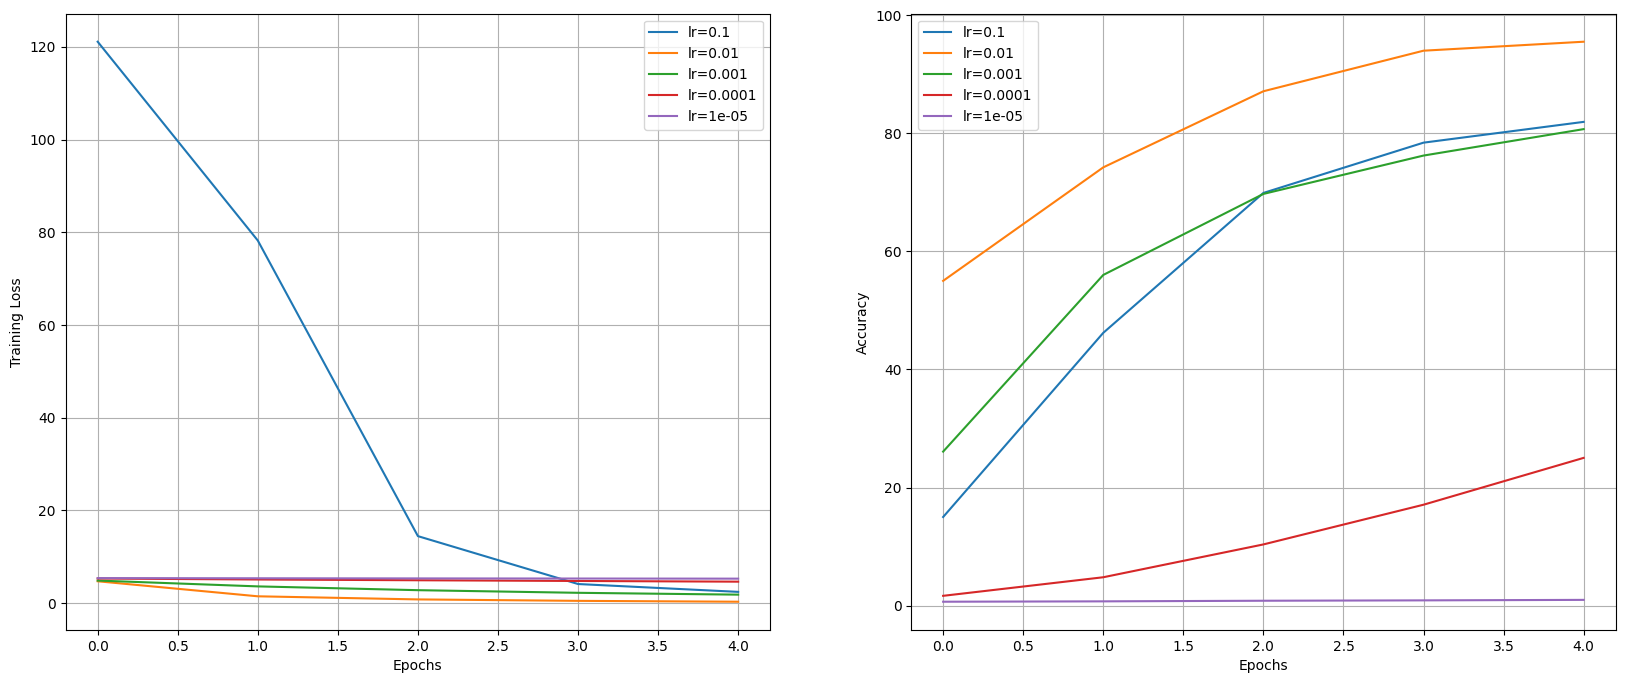

In [62]:
adam_lr_loss, adam_lr_accuracy = [], []
lr_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in lr_rates:
    print(lr)
    checkModel = copy.deepcopy(model_1d)
    checkModel.to(device)

    optimizer = optim.Adam(params=checkModel.parameters(), lr=lr, weight_decay=0.0001)

    torch.cuda.empty_cache()
    gc.collect()

    training_loss, training_accuracy = overfit_model(checkModel, TrainFeatureLoader, 
                                                        optimizer, criterion, num_epochs=5)

    adam_lr_loss.append(training_loss)
    adam_lr_accuracy.append(training_accuracy)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(len(lr_rates)):
    ax[0].plot(range(len(adam_lr_loss[i])), adam_lr_loss[i], label=f"lr={lr_rates[i]}")
    ax[1].plot(range(len(adam_lr_accuracy[i])), adam_lr_accuracy[i], label=f"lr={lr_rates[i]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

## Coarse grid (train for 1-5 epochs)

Choose a few values of learning rate and weight decay around what worked on step 3, tain a few models for 1-5 epochs

Good weight decay to try: 1e-4, 1e-5, 0

In [63]:
adam_lr_wd_loss, adam_lr_wd_accuracy = [], []
# lr_rates = np.random.uniform(3/4 * 1e-3, 4/3 * 1e-3, size=9)
# lr_rates = [1e-2, 1e-3, 1e-4, 1e-5]
weight_decay = np.array([0, 1e-4, 1e-5])
lr = 1e-2
for wd in weight_decay:
    print(f"lr={lr}, wd={wd}")
    checkModel = copy.deepcopy(model_1d)
    checkModel.to(device)

    optimizer = optim.Adam(params=checkModel.parameters(), lr=lr, weight_decay=wd)

    torch.cuda.empty_cache()
    gc.collect()

    training_loss, training_accuracy = overfit_model(checkModel, TrainFeatureLoader, 
                                                        optimizer, criterion, num_epochs=5)

    adam_lr_wd_loss.append(training_loss)
    adam_lr_wd_accuracy.append(training_accuracy)
    print()


lr=0.01, wd=0.0


100%|██████████| 38/38 [00:03<00:00, 10.82it/s]


Epoch [1/5], Loss: 3.0219


100%|██████████| 38/38 [00:02<00:00, 14.20it/s]


Accuracy of the network on the 38 train images: 54.5625


100%|██████████| 38/38 [00:02<00:00, 14.46it/s]


Epoch [2/5], Loss: 1.4860


100%|██████████| 38/38 [00:02<00:00, 14.79it/s]


Accuracy of the network on the 38 train images: 75.60416666666667


100%|██████████| 38/38 [00:02<00:00, 14.41it/s]


Epoch [3/5], Loss: 0.7298


100%|██████████| 38/38 [00:02<00:00, 14.89it/s]


Accuracy of the network on the 38 train images: 85.85416666666667


100%|██████████| 38/38 [00:02<00:00, 14.41it/s]


Epoch [4/5], Loss: 0.6218


100%|██████████| 38/38 [00:02<00:00, 14.70it/s]


Accuracy of the network on the 38 train images: 92.66666666666667


100%|██████████| 38/38 [00:02<00:00, 14.50it/s]


Epoch [5/5], Loss: 0.4645


100%|██████████| 38/38 [00:02<00:00, 14.90it/s]


Accuracy of the network on the 38 train images: 94.75

lr=0.01, wd=0.0001


100%|██████████| 38/38 [00:02<00:00, 14.76it/s]


Epoch [1/5], Loss: 2.7876


100%|██████████| 38/38 [00:02<00:00, 14.54it/s]


Accuracy of the network on the 38 train images: 52.104166666666664


100%|██████████| 38/38 [00:02<00:00, 14.24it/s]


Epoch [2/5], Loss: 1.4063


100%|██████████| 38/38 [00:02<00:00, 14.43it/s]


Accuracy of the network on the 38 train images: 77.91666666666667


100%|██████████| 38/38 [00:02<00:00, 14.21it/s]


Epoch [3/5], Loss: 0.8275


100%|██████████| 38/38 [00:02<00:00, 14.99it/s]


Accuracy of the network on the 38 train images: 86.14583333333333


100%|██████████| 38/38 [00:02<00:00, 15.15it/s]


Epoch [4/5], Loss: 0.4758


100%|██████████| 38/38 [00:02<00:00, 15.32it/s]


Accuracy of the network on the 38 train images: 91.60416666666667


100%|██████████| 38/38 [00:02<00:00, 14.87it/s]


Epoch [5/5], Loss: 0.4262


100%|██████████| 38/38 [00:02<00:00, 14.91it/s]


Accuracy of the network on the 38 train images: 93.83333333333333

lr=0.01, wd=1e-05


100%|██████████| 38/38 [00:02<00:00, 14.74it/s]


Epoch [1/5], Loss: 2.3465


100%|██████████| 38/38 [00:02<00:00, 14.81it/s]


Accuracy of the network on the 38 train images: 54.604166666666664


100%|██████████| 38/38 [00:02<00:00, 13.64it/s]


Epoch [2/5], Loss: 1.3755


100%|██████████| 38/38 [00:02<00:00, 14.80it/s]


Accuracy of the network on the 38 train images: 75.66666666666667


100%|██████████| 38/38 [00:02<00:00, 15.09it/s]


Epoch [3/5], Loss: 0.6295


100%|██████████| 38/38 [00:02<00:00, 14.95it/s]


Accuracy of the network on the 38 train images: 89.3125


100%|██████████| 38/38 [00:02<00:00, 14.90it/s]


Epoch [4/5], Loss: 0.6461


100%|██████████| 38/38 [00:02<00:00, 15.04it/s]


Accuracy of the network on the 38 train images: 92.0625


100%|██████████| 38/38 [00:02<00:00, 15.22it/s]


Epoch [5/5], Loss: 0.4538


100%|██████████| 38/38 [00:02<00:00, 15.40it/s]

Accuracy of the network on the 38 train images: 95.64583333333333



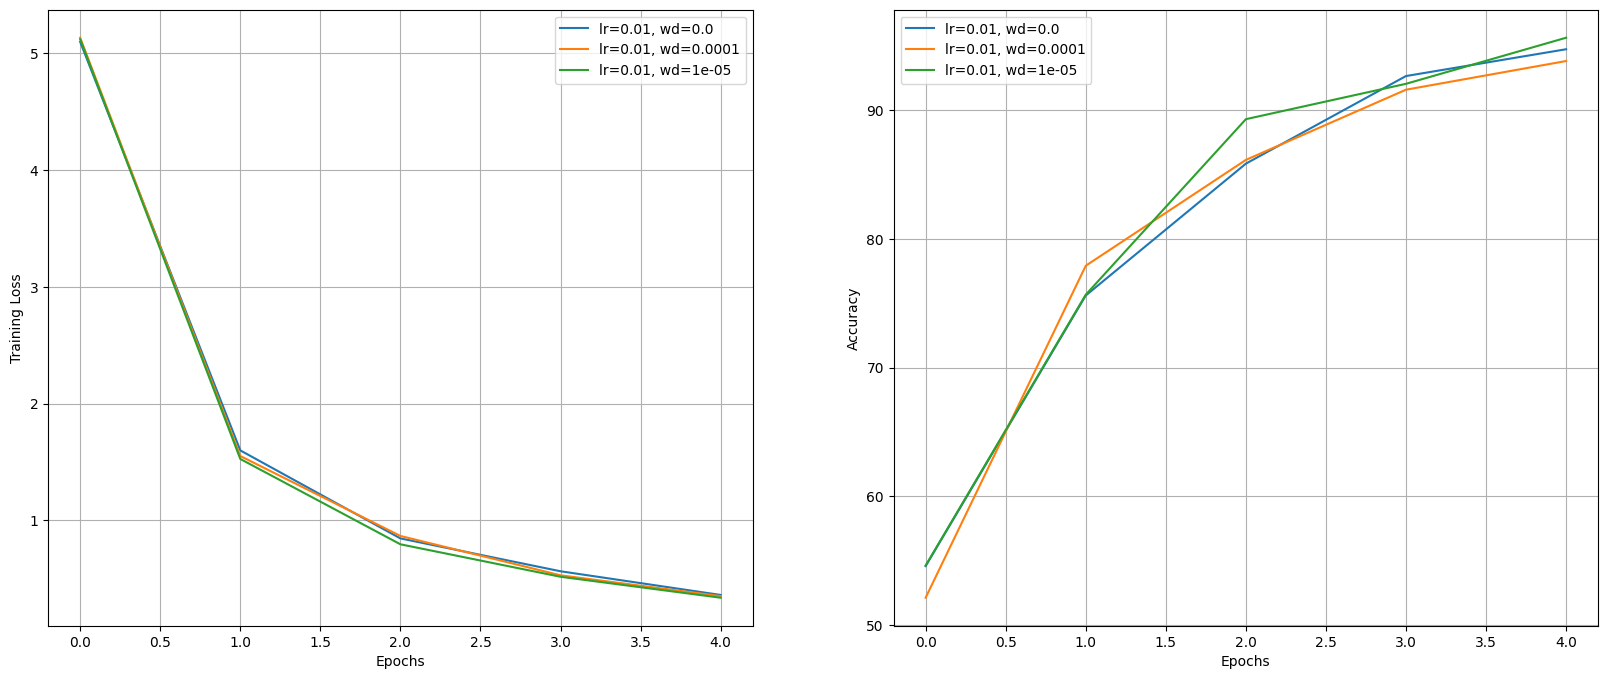

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

for j in range(len(weight_decay)):
    ax[0].plot(range(len(adam_lr_wd_loss[j])), 
                adam_lr_wd_loss[j], 
                label=f"lr={lr}, wd={weight_decay[j]}")
    
    ax[1].plot(range(len(adam_lr_wd_accuracy[j])), 
                adam_lr_wd_accuracy[j], 
                label=f"lr={lr}, wd={weight_decay[j]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

## Refine grid, train longer

Pick best models from coarse grid, train them for longer (~10-20 epochs) without learning decay.

Check for
- Loss curves bad initialization:
    - if there is a plateau at the initial stage of the curve.
    - if there is a plateau at the end of the curve (implying the need for learning decay).
- Train and Validation accuracy curves:
    - Overfitting
    - Underfitting

# Training
There is a small error while printing loss. I printed final batch's loss after an epoch instead of whole batches' loss.

In [65]:
checkModel = copy.deepcopy(model_1d)
checkModel.to(device)

torch.cuda.empty_cache()
gc.collect()

training_accuracy = []
training_loss = []
validation_accuracy = []

# Number of epochs
num_epochs = 20

optimizer = optim.Adam(params=checkModel.parameters(), lr=1e-2, weight_decay=1e-5)

for epoch in range(num_epochs):
    checkModel.train()

    running_loss = 0    
    for input_data, labels in tqdm.tqdm(TrainFeatureLoader, total=len(TrainFeatureLoader)):
        # Forward pass
        labels, input_data = labels.to(device), input_data.to(device)
        output = checkModel(input_data)
        
        # Compute loss
        loss = criterion(output, labels.long())
        running_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
    # scheduler.step(running_loss)  # Update learning rate
        
    # Print training progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    training_loss.append(running_loss / len(TrainFeatureLoader))

    training_accuracy.append(calculate_accuracy(checkModel, TrainFeatureLoader, data_type='train'))
    validation_accuracy.append(calculate_accuracy(checkModel, ValidationFeatureLoader, data_type='validation'))
    

    # if (epoch + 1) % 10 == 0:
    #     fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    #     ax[0].plot(range(len(training_loss)), training_loss)
    #     ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
    #     ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
    #     ax[1].grid()
    #     ax[0].grid()
    #     ax[0].set_xlabel('Epochs')
    #     ax[0].set_ylabel('Training Loss')
    #     ax[1].set_xlabel('Epochs')
    #     ax[1].set_ylabel('Accuracy')
    #     ax[1].legend()
    #     plt.show()
        # torch.save(checkModel.state_dict(), f"checkModel_{epoch}.pth")
calculate_accuracy(checkModel, TestFeatureLoader, data_type='test')

100%|██████████| 38/38 [00:02<00:00, 14.06it/s]


Epoch [1/20], Loss: 2.9455


100%|██████████| 38/38 [00:02<00:00, 15.05it/s]


Accuracy of the network on the 38 train images: 57.270833333333336


100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


Accuracy of the network on the 10 validation images: 41.87604690117253


100%|██████████| 38/38 [00:02<00:00, 14.79it/s]


Epoch [2/20], Loss: 1.2301


100%|██████████| 38/38 [00:02<00:00, 14.98it/s]


Accuracy of the network on the 38 train images: 77.14583333333333


100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Accuracy of the network on the 10 validation images: 52.01005025125628


100%|██████████| 38/38 [00:02<00:00, 14.58it/s]


Epoch [3/20], Loss: 0.5730


100%|██████████| 38/38 [00:02<00:00, 14.44it/s]


Accuracy of the network on the 38 train images: 87.72916666666667


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


Accuracy of the network on the 10 validation images: 57.6214405360134


100%|██████████| 38/38 [00:02<00:00, 14.46it/s]


Epoch [4/20], Loss: 0.5811


100%|██████████| 38/38 [00:02<00:00, 14.87it/s]


Accuracy of the network on the 38 train images: 92.91666666666667


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


Accuracy of the network on the 10 validation images: 57.70519262981575


100%|██████████| 38/38 [00:02<00:00, 14.16it/s]


Epoch [5/20], Loss: 0.2582


100%|██████████| 38/38 [00:02<00:00, 15.09it/s]


Accuracy of the network on the 38 train images: 96.08333333333333


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


Accuracy of the network on the 10 validation images: 61.139028475711896


100%|██████████| 38/38 [00:02<00:00, 14.54it/s]


Epoch [6/20], Loss: 0.2714


100%|██████████| 38/38 [00:02<00:00, 14.80it/s]


Accuracy of the network on the 38 train images: 97.52083333333333


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


Accuracy of the network on the 10 validation images: 61.05527638190955


100%|██████████| 38/38 [00:02<00:00, 14.93it/s]


Epoch [7/20], Loss: 0.1528


100%|██████████| 38/38 [00:02<00:00, 14.87it/s]


Accuracy of the network on the 38 train images: 99.0


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


Accuracy of the network on the 10 validation images: 63.98659966499162


100%|██████████| 38/38 [00:02<00:00, 14.31it/s]


Epoch [8/20], Loss: 0.1041


100%|██████████| 38/38 [00:02<00:00, 15.10it/s]


Accuracy of the network on the 38 train images: 99.83333333333333


100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


Accuracy of the network on the 10 validation images: 64.321608040201


100%|██████████| 38/38 [00:02<00:00, 14.67it/s]


Epoch [9/20], Loss: 0.0525


100%|██████████| 38/38 [00:02<00:00, 15.20it/s]


Accuracy of the network on the 38 train images: 99.97916666666667


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Accuracy of the network on the 10 validation images: 64.07035175879398


100%|██████████| 38/38 [00:02<00:00, 14.75it/s]


Epoch [10/20], Loss: 0.0312


100%|██████████| 38/38 [00:02<00:00, 15.23it/s]


Accuracy of the network on the 38 train images: 99.97916666666667


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


Accuracy of the network on the 10 validation images: 65.74539363484087


100%|██████████| 38/38 [00:02<00:00, 14.80it/s]


Epoch [11/20], Loss: 0.0442


100%|██████████| 38/38 [00:02<00:00, 15.09it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Accuracy of the network on the 10 validation images: 65.91289782244556


100%|██████████| 38/38 [00:02<00:00, 14.71it/s]


Epoch [12/20], Loss: 0.0334


100%|██████████| 38/38 [00:02<00:00, 15.06it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


Accuracy of the network on the 10 validation images: 66.1641541038526


100%|██████████| 38/38 [00:02<00:00, 14.96it/s]


Epoch [13/20], Loss: 0.0248


100%|██████████| 38/38 [00:02<00:00, 14.65it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


Accuracy of the network on the 10 validation images: 65.82914572864321


100%|██████████| 38/38 [00:02<00:00, 14.87it/s]


Epoch [14/20], Loss: 0.0362


100%|██████████| 38/38 [00:02<00:00, 14.74it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Accuracy of the network on the 10 validation images: 66.41541038525963


100%|██████████| 38/38 [00:02<00:00, 14.94it/s]


Epoch [15/20], Loss: 0.0226


100%|██████████| 38/38 [00:02<00:00, 14.69it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


Accuracy of the network on the 10 validation images: 66.08040201005025


100%|██████████| 38/38 [00:02<00:00, 14.74it/s]


Epoch [16/20], Loss: 0.0223


100%|██████████| 38/38 [00:02<00:00, 14.90it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


Accuracy of the network on the 10 validation images: 66.08040201005025


100%|██████████| 38/38 [00:02<00:00, 14.62it/s]


Epoch [17/20], Loss: 0.0196


100%|██████████| 38/38 [00:02<00:00, 14.35it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


Accuracy of the network on the 10 validation images: 65.74539363484087


100%|██████████| 38/38 [00:02<00:00, 14.63it/s]


Epoch [18/20], Loss: 0.0178


100%|██████████| 38/38 [00:02<00:00, 14.88it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Accuracy of the network on the 10 validation images: 65.9966499162479


100%|██████████| 38/38 [00:02<00:00, 14.78it/s]


Epoch [19/20], Loss: 0.0140


100%|██████████| 38/38 [00:02<00:00, 14.92it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


Accuracy of the network on the 10 validation images: 66.1641541038526


100%|██████████| 38/38 [00:02<00:00, 14.38it/s]


Epoch [20/20], Loss: 0.0153


100%|██████████| 38/38 [00:02<00:00, 14.66it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Accuracy of the network on the 10 validation images: 66.49916247906198


100%|██████████| 46/46 [00:09<00:00,  4.85it/s]

Accuracy of the network on the 46 test images: 66.82775284777355


66.82775284777355

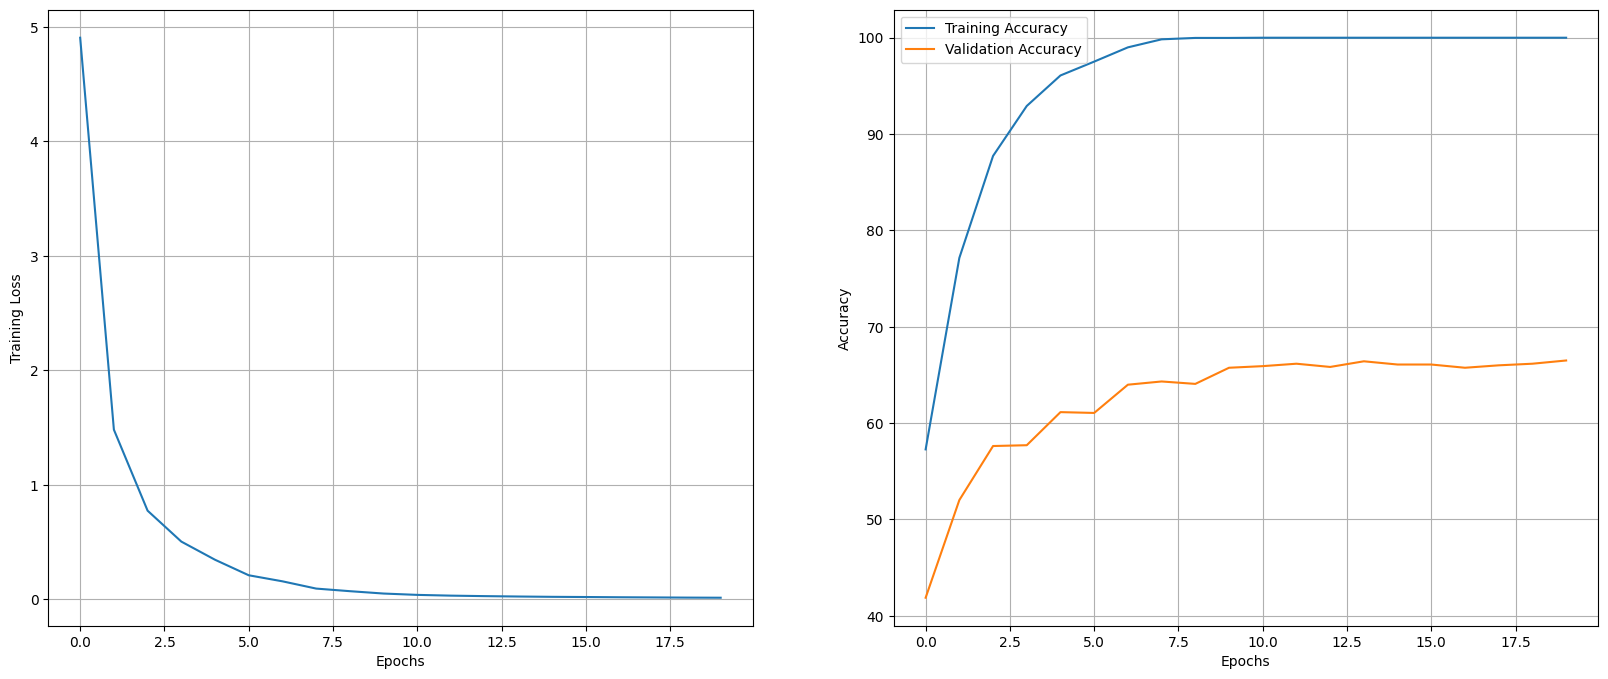

In [66]:

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(range(len(training_loss)), training_loss)
ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
ax[1].grid()
ax[0].grid()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()
torch.save(checkModel.state_dict(), f"DenseNet121_FeatureExtraction_1D_1e-2_lr_1e-5_wd_20_epoch.pth")

# Check the downloaded model 

Comparing whether the model developed is working in properly

In [24]:
#Filling all the trained parameters
check_model_1d = NeuralNetwork1D(1024, 200)
load_model = torch.load("DenseNet121_FeatureExtraction_1D_1e-2_lr_1e-5_wd_20_epoch.pth")
check_model_1d.load_state_dict(load_model)
check_model_1d.to(device)

#Imagenet parameters
imgnet_densenet121 = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
imgnet_densenet121.classifier = nn.Identity()

for param in imgnet_densenet121.parameters():
    param.requires_grad = False
imgnet_densenet121.to(device)

#Combining the two models
check_model_1d = nn.Sequential(imgnet_densenet121, check_model_1d)

Check with the test loader whether the accuracy of 66.82% was right

In [25]:
calculate_accuracy(check_model_1d, TestLoader, data_type='test')

100%|██████████| 2897/2897 [01:40<00:00, 28.93it/s]

Accuracy of the network on the 2897 test images: 66.82775284777355


66.82775284777355

Yes, the model is working as it is said

# GRAD CAM

In [20]:
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

def generate_cam(image, labels, model, target_layers, transform):
    #Display image 
    display_image = image.resize((224, 224))
    required_image = np.array(display_image) / 255

    transformed_image = transform(image)
    model.eval()

    #Grad CAM for each target layer
    images = display_image
    for i, label in enumerate(labels):
        targets = [ClassifierOutputTarget(label)]
        
        cam = GradCAM(model=model, target_layers=target_layers)#, use_cuda=True) 

        gray_cam = cam(input_tensor=transformed_image.unsqueeze(0), targets=targets, aug_smooth=True)

        cam_image = show_cam_on_image(required_image, gray_cam[0, :], use_rgb=True)

        images = np.hstack((images, cam_image))

    return Image.fromarray(images)

In [41]:
#Filling all the trained parameters
test_model_1d = NeuralNetwork1D(1024, 200)
load_model = torch.load("DenseNet121_FeatureExtraction_1D_1e-2_lr_1e-5_wd_20_epoch.pth")
test_model_1d.load_state_dict(load_model)
test_model_1d.to(device)

#Imagenet parameters
test_densenet121 = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
test_densenet121.classifier = nn.Identity()
test_densenet121.to(device)

#Combining the two models
grad_model_1d = nn.Sequential(test_densenet121, test_model_1d)
grad_model_1d.to(device)

Sequential(
  (0): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, a

The images are as follows: Normal resized image to 224x224, CAM for predicted label, CAM for actual label
Predicted: 181, Actual: 181, 
            Predicted probability: 0.9844927787780762


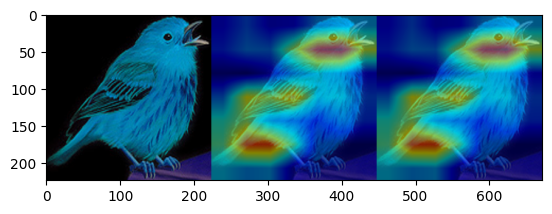

Predicted: 149, Actual: 126, 
            Predicted probability: 0.7918230295181274


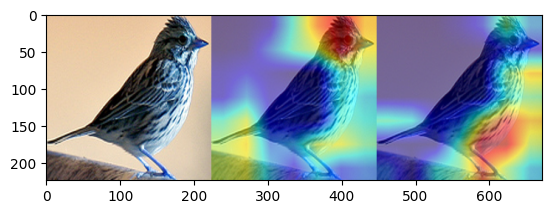

Predicted: 26, Actual: 25, 
            Predicted probability: 0.4713926613330841


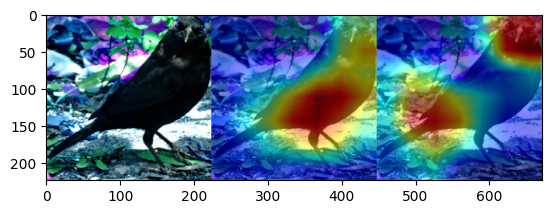

Predicted: 175, Actual: 173, 
            Predicted probability: 0.2739975154399872


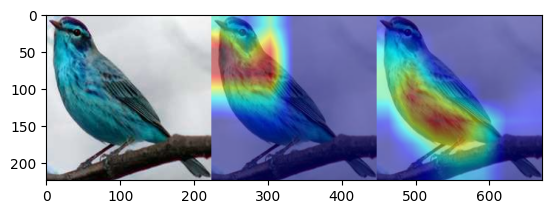

Predicted: 128, Actual: 128, 
            Predicted probability: 0.6222307085990906


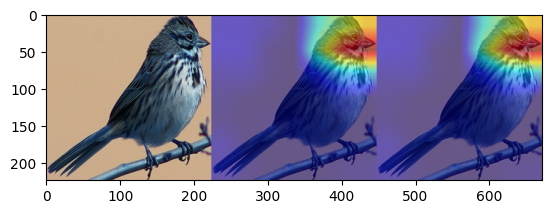

Predicted: 111, Actual: 110, 
            Predicted probability: 0.618116021156311


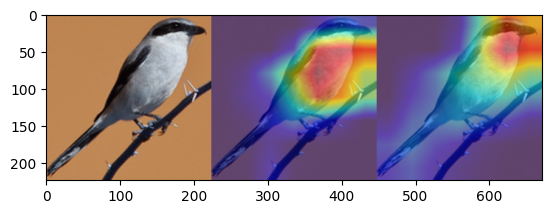

Predicted: 168, Actual: 168, 
            Predicted probability: 0.9463829398155212


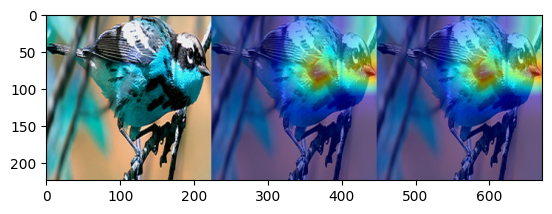

Predicted: 131, Actual: 131, 
            Predicted probability: 0.8160578608512878


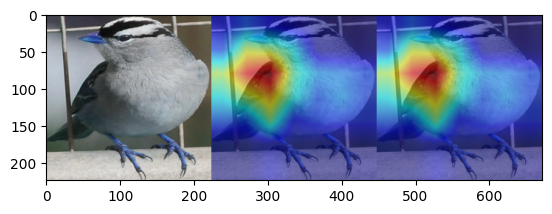

Predicted: 38, Actual: 36, 
            Predicted probability: 0.6317287683486938


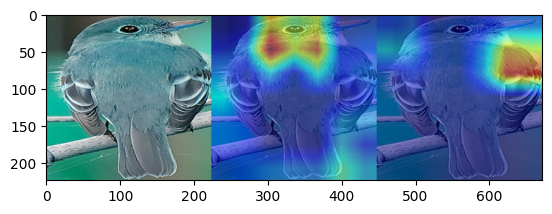

Predicted: 36, Actual: 38, 
            Predicted probability: 0.7609250545501709


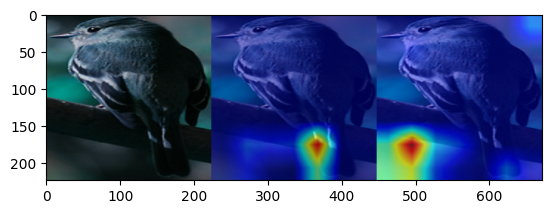

In [47]:
rand_val = np.random.randint(len(X_test), size=10)

print("The images are as follows: Normal resized image to 224x224, CAM for predicted label, CAM for actual label")
for i in rand_val:
    #Get the image and label
    image = Image.fromarray(X_temp_test[i])
    label = y_test[i]
    target_layers = [grad_model_1d[0].features.denseblock4.denselayer16.conv2]
    
    #Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    #Predict the image
    grad_model_1d.eval()
    output = grad_model_1d(transform(image).unsqueeze(0).to(device))
    result = nn.Softmax(dim=1)(output)
    predicted = torch.argmax(output, dim=1).item()
    print(f"""Predicted: {predicted}, Actual: {label.item()}, 
            Predicted probability: {result[0][predicted].item()}""")
    
    #Generate CAM
    cam_image = generate_cam(image, [predicted, label], grad_model_1d, target_layers, transform)
    plt.imshow(cam_image)
    plt.show()

We can observe that the last layer of CAM is most of the time highlighting the bird rather than the background. This implies that the model is good.